In [1]:
#@title Import libraries
from easydict import EasyDict

import numpy as np
import torch
import clip

from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import patches

import collections
import json
import numpy as np

import os
import os.path as osp

from PIL import Image
from pprint import pprint
from scipy.special import softmax
import yaml

import tensorflow.compat.v1 as tf # version .1

import cv2

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

/Applications/anaconda3/envs/zeroShot/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title Define hyperparameters
FLAGS = {
    'prompt_engineering': True,
    'this_is': True,
    
    'temperature': 100.0,
    'use_softmax': False,
}
FLAGS = EasyDict(FLAGS)

# Global matplotlib settings
SMALL_SIZE = 16#10
MEDIUM_SIZE = 18#12
BIGGER_SIZE = 20#14
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Parameters for drawing figure.
display_input_size = (10, 10)
overall_fig_size = (18, 24)
line_thickness = 2
fig_size_w = 35
# fig_size_h = min(max(5, int(len(category_names) / 2.5) ), 10)
mask_color =   'red'
alpha = 0.5

## Build text embeddings

We use the CLIP model from OpenAI: https://github.com/openai/CLIP.

In [3]:
def article(name):  #% A/An
  return 'an' if name[0] in 'aeiou' else 'a'


def processed_name(name, rm_dot=False):  #% '_' for lvis, '/' for obj365
  res = name.replace('_', ' ').replace('/', ' or ').lower()
  if rm_dot:
    res = res.rstrip('.')
  return res


# //////////////////////////////////////////////////////////////
single_template = [  #% Only one
    'a photo of {article} {}.'
]
# //////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////
multiple_templates = [
    'There is {article} {} in the scene.',
    'There is the {} in the scene.',
    'a photo of {article} {} in the scene.',
    'a photo of the {} in the scene.',
    'a photo of one {} in the scene.',

    'itap of {article} {}.',
    'itap of my {}.',  # itap: I took a picture of
    'itap of the {}.',
    
    'a photo of {article} {}.',
    'a photo of my {}.',
    'a photo of the {}.',
    'a photo of one {}.',
    'a photo of many {}.',

    'a good photo of {article} {}.',
    'a good photo of the {}.',
    'a bad photo of {article} {}.',
    'a bad photo of the {}.',
    'a photo of a nice {}.',
    'a photo of the nice {}.',
    'a photo of a cool {}.',
    'a photo of the cool {}.',
    'a photo of a weird {}.',
    'a photo of the weird {}.',

    'a photo of a small {}.',
    'a photo of the small {}.',
    'a photo of a large {}.',
    'a photo of the large {}.',

    'a photo of a clean {}.',
    'a photo of the clean {}.',
    'a photo of a dirty {}.',
    'a photo of the dirty {}.',

    'a bright photo of {article} {}.',
    'a bright photo of the {}.',
    'a dark photo of {article} {}.',
    'a dark photo of the {}.',

    'a photo of a hard to see {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of {article} {}.',
    'a low resolution photo of the {}.',
    'a cropped photo of {article} {}.',
    'a cropped photo of the {}.',
    'a close-up photo of {article} {}.',
    'a close-up photo of the {}.',
    'a jpeg corrupted photo of {article} {}.',
    'a jpeg corrupted photo of the {}.',
    'a blurry photo of {article} {}.',
    'a blurry photo of the {}.',
    'a pixelated photo of {article} {}.',
    'a pixelated photo of the {}.',

    'a black and white photo of the {}.',
    'a black and white photo of {article} {}.',

    'a plastic {}.',
    'the plastic {}.',

    'a toy {}.',
    'the toy {}.',
    'a plushie {}.',
    'the plushie {}.',
    'a cartoon {}.',
    'the cartoon {}.',

    'an embroidered {}.',
    'the embroidered {}.',

    'a painting of the {}.',
    'a painting of a {}.',
]
# //////////////////////////////////////////////////////////////




clip.available_models()
model, preprocess = clip.load("ViT-B/32")




#///////////////////////////////////////////
#     Build text embedding function:
def build_text_embedding(categories):
  if FLAGS.prompt_engineering:  ## prompt engineering => some templates
    templates = multiple_templates
  else:
    templates = single_template

  with torch.no_grad():
    all_text_embeddings = []  ## All Text Embeddings
    print('Building text embeddings...')
    
    for category in tqdm(categories):
      texts = [
        template.format(processed_name(category['name'], rm_dot=True),
                        article=article(category['name']))
        for template in templates
      ]
      if FLAGS.this_is:
        texts = [
                 'This is ' + text if text.startswith('a') or text.startswith('the') else text 
                 for text in texts
                 ]
      texts = clip.tokenize(texts) #@ Returns a LongTensor containing tokenized sequences of given text input(s).
      #TODO print("texts[tokenized sequences of given text inputs]: ", texts) ## This can be used as the input to the model.
      if torch.cuda.is_available():
        texts = texts.cuda()
      
      #@ Given a batch of text tokens, returns the text features encoded by the language portion of the CLIP model.  
      text_embeddings = model.encode_text(texts) #embed with text encoder 
      text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
      text_embedding = text_embeddings.mean(dim=0)
      text_embedding /= text_embedding.norm()
      all_text_embeddings.append(text_embedding)
    ## FOR ENDING  
    all_text_embeddings = torch.stack(all_text_embeddings, dim=1)
    if torch.cuda.is_available():
      all_text_embeddings = all_text_embeddings.cuda()
  ## WITH ENDING  
  return all_text_embeddings.cpu().numpy().T

### Load ViLD model

In [5]:
session = tf.Session(graph=tf.Graph())

saved_model_dir = './image_path_v2' #@param {type:"string"}

_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir) # Restoring parameters from ./image_path_v2/variables/variables

INFO:tensorflow:Restoring parameters from ./image_path_v2/variables/variables


2022-07-08 22:50:50.721265: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


## Helper functioins

In [8]:
numbered_categories = [{'name': str(idx), 'id': idx,} for idx in range(50)]
# print(numbered_categories)  # [{'name': '0', 'id': 0}, {, ..., {'name': '49', 'id': 49}]
numbered_category_indices = {cat['id']: cat for cat in numbered_categories}
# print(numbered_category_indices)  # 0: {'name': '0', 'id': 0}, ..., 49: {'name': '49', 'id': 49}}

#@ Non Maximum Suppression
#@ dets: [N, 4] 
#@ scores: [N,]
#@ thresh[Float]: iou threshold.
#@ max_dets[Int]
def nms(dets, scores, thresh, max_dets=1000):
  y1 = dets[:, 0]
  x1 = dets[:, 1]
  y2 = dets[:, 2]
  x2 = dets[:, 3]

  areas = (x2 - x1) * (y2 - y1)
  order = scores.argsort()[::-1]

  keep = []
  while order.size > 0 and len(keep) < max_dets:
    i = order[0]
    keep.append(i)

    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])

    w = np.maximum(0.0, xx2 - xx1)
    h = np.maximum(0.0, yy2 - yy1)
    intersection = w * h
    overlap = intersection / (areas[i] + areas[order[1:]] - intersection + 1e-12)

    inds = np.where(overlap <= thresh)[0]
    order = order[inds + 1]
  ## WHILE ENDING 
  return keep

# Visual

In [9]:
#@title Visualization
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

STANDARD_COLORS = [  ## Color Choices
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque', 'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite', 'Chocolate', 'Coral', 
    'CornflowerBlue', 'Cornsilk', 'Cyan', 'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange', 'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet', 
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FloralWhite', 'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod', 'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'Ivory',
    'Khaki', 'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue', 'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey', 'LightGreen', 'LightPink',
    'LightSalmon', 'LightSeaGreen', 'LightSkyBlue', 'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime', 'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 
    'MediumOrchid', 'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen', 'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin', 'NavajoWhite',
    'OldLace', 'Olive', 'OliveDrab', 'Orange', 'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed', 'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue',
    'Purple', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown', 'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue', 'SlateGray', 'SlateGrey', 'Snow', 
    'SpringGreen', 'SteelBlue', 'GreenYellow', 'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White', 'WhiteSmoke', 'Yellow', 'YellowGreen'
]

#* #########################################################
#@ Draw_boxes function
#@ image: a PIL.Image object.
#@ display_str_list: list of strings to display in box (out of range => displaying below the box)
#@ use_normalized_coordinates: True (default) => treat coordinates as relative to the image. Otherwise => absolute.
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax,
                               color='red', thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
  
  try:
    font = ImageFont.truetype('arial.ttf', 24)
  except IOError:
    font = ImageFont.load_default()

  #@ Displayed string position adjustment 
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)   # display_str has top and bottom margin_(0.05x).
  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  for display_str in display_str_list[::-1]:  ## Reverse str position
    text_left = min(5, left)
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
    draw.text( (left + margin, text_bottom - text_height - margin),
               display_str, 
               fill='black',
               font=font)
    text_bottom -= text_height - 2 * margin



#* #########################################################
#@ Draw_box on image (numpy array form) {CALL draw_bounding_box_on_image()}
#@ image: a numpy array with shape [height, width, 3].
def draw_bounding_box_on_image_array(image, ymin, xmin, ymax, xmax,
                                     color='red', thickness=4,
                                     display_str_list=(),
                                     use_normalized_coordinates=True):
  image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
  draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, thickness, display_str_list, use_normalized_coordinates)
  np.copyto(image, np.array(image_pil))  # image flush



#* #########################################################
#@ Draw mask on image(numpy array)
#@ image: uint8 numpy array with shape [img_height, img_height, 3]
#@ mask: uint8 numpy array in shape [img_height, img_height] with values [0 / 1].
def draw_mask_on_image_array(image, mask, color='red', alpha=0.4):
  if image.dtype != np.uint8:
    raise ValueError('`image` not of type np.uint8')
  if mask.dtype != np.uint8:
    raise ValueError('`mask` not of type np.uint8')
  if np.any(np.logical_and(mask != 1, mask != 0)):
    raise ValueError('`mask` elements should be in [0, 1]')
  if image.shape[:2] != mask.shape:
    raise ValueError('The image has spatial dimensions %s, but the mask has dimensions %s' % (image.shape[:2], mask.shape))
  
  rgb = ImageColor.getrgb(color)
  pil_image = Image.fromarray(image)

  solid_color = np.expand_dims(np.ones_like(mask), axis=2) * np.reshape(list(rgb), [1, 1, 3])
  pil_solid_color = Image.fromarray(np.uint8(solid_color)).convert('RGBA')
  pil_mask = Image.fromarray(np.uint8(255.0*alpha*mask)).convert('L')
  pil_image = Image.composite(pil_solid_color, pil_image, pil_mask)
  np.copyto(image, np.array(pil_image.convert('RGB')))
#* #########################################################
#@ Plot the mask 
def plot_mask(color, alpha, original_image, mask):  #! Simialr to draw_mask_on_image_array()
  rgb = ImageColor.getrgb(color)
  pil_image = Image.fromarray(original_image)

  solid_color = np.expand_dims(np.ones_like(mask), axis=2) * np.reshape(list(rgb), [1, 1, 3])
  pil_solid_color = Image.fromarray(np.uint8(solid_color)).convert('RGBA')
  pil_mask = Image.fromarray(np.uint8(255.0*alpha*mask)).convert('L')
  pil_image = Image.composite(pil_solid_color, pil_image, pil_mask)
  ## Maintain the original image
  img_w_mask = np.array(pil_image.convert('RGB'))
  return img_w_mask




#* #########################################################
#@ Visualize labeled boxes, scores
#@ image: uint8 numpy array [img_height, img_width, 3]
#@ boxes: numpy array [N, 4]
#@ classes: numpy array [N]. Note that class indices are 1-based and match the keys in the label map.
#@ scores: numpy array [N] or None(assumes plotted boxes are groundtruth boxes. Plot all boxes as black without classes/scores)
#@ category_index: a dict [[category index `id`, category name `name`] keyed by category indices]
#@
#@ instance_masks: numpy array [N, image_height, image_width] with values [0/1]
#@ instance_boundaries: numpy array [N, image_height, image_width] with values [0/1]
#@
#@ agnostic_mode[boolean]: class-agnostic mode_(display scores but ignore classes)
def visualize_boxes_and_labels_on_image_array(image, boxes, classes, scores, category_index,
                                              instance_masks=None, instance_boundaries=None,
                                              use_normalized_coordinates=False,
                                              max_boxes_to_draw=20, min_score_thresh=.5, #max number of boxes and  minimum score to visualize
                                              agnostic_mode=False,
                                              line_thickness=4,
                                              groundtruth_box_visualization_color='black',
                                              skip_scores=False, skip_labels=False,
                                              mask_alpha=0.4,
                                              plot_color=None,):
  ## Create a display string(color) for each boxLoc, group any that correspond to one same loc.
  #////////////////////////////////////////////////////////////
  box_to_display_str_map = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  box_to_instance_masks_map = {}
  box_to_score_map = {}
  box_to_instance_boundaries_map = {}
  
  if not max_boxes_to_draw:
    max_boxes_to_draw = boxes.shape[0]
    
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if scores is None or scores[i] > min_score_thresh:
      box = tuple(boxes[i].tolist())
      if instance_masks is not None:
        box_to_instance_masks_map[box] = instance_masks[i]
      if instance_boundaries is not None:
        box_to_instance_boundaries_map[box] = instance_boundaries[i]
      if scores is None:
        box_to_color_map[box] = groundtruth_box_visualization_color
      
      else:
        display_str = ''
        if not skip_labels:
          if not agnostic_mode:
            if classes[i] in list(category_index.keys()):
              class_name = category_index[classes[i]]['name']
            else:
              class_name = 'N/A'
            display_str = str(class_name)
        ## SKIP_LABELS IF ENDING
        if not skip_scores:
          if not display_str:
            display_str = '{}%'.format(int(100*scores[i]))
          else:
            float_score = ("%.2f" % scores[i]).lstrip('0')
            display_str = '{}: {}'.format(display_str, float_score)
          box_to_score_map[box] = int(100*scores[i])
        ## SKIP_SCORES IF ENDING 
        box_to_display_str_map[box].append(display_str)
        if plot_color is not None:
          box_to_color_map[box] = plot_color
        elif agnostic_mode:
          box_to_color_map[box] = 'DarkOrange'
        else:
          box_to_color_map[box] = STANDARD_COLORS[
              classes[i] % len(STANDARD_COLORS)]
  
  ## Handle the case when box_to_score_map is empty.
  #////////////////////////////////////////////////////////////
  if box_to_score_map:
    box_color_iter = sorted(box_to_color_map.items(), key=lambda kv: box_to_score_map[kv[0]])
  else:
    box_color_iter = box_to_color_map.items()

  ## Draw all boxes onto image.
  #////////////////////////////////////////////////////////////
  for box, color in box_color_iter:
    ymin, xmin, ymax, xmax = box
    if instance_masks is not None:
      draw_mask_on_image_array(image, box_to_instance_masks_map[box], color=color, alpha=mask_alpha)
    if instance_boundaries is not None:
      draw_mask_on_image_array(image, box_to_instance_boundaries_map[box], color='red', alpha=1.0)
    draw_bounding_box_on_image_array(image, ymin, xmin, ymax, xmax,
                                     color=color, thickness=line_thickness,
                                     display_str_list=box_to_display_str_map[box],
                                     use_normalized_coordinates=use_normalized_coordinates)
  return image   #@ Return uint8 numpy array [img_height, img_width, 3] with overlaid boxes.








#* #########################################################
#@ Generate the image segmentation results.
#@ masks: numpy array [N, mask_height, mask_width] => the instance masks w.r.t. the `detected_boxes`.
#@ detected_boxes: numpy array [N, 4] representing the reference bounding boxes.
def paste_instance_masks(masks, detected_boxes, image_height, image_width):
  def expand_boxes(boxes, scale):
    """Expands an array of boxes by a given scale."""
    # Reference: https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/boxes.py#L227  # pylint: disable=line-too-long
    # The `boxes` in the reference implementation is in [x1, y1, x2, y2] form, whereas `boxes` here is in [x1, y1, w, h] form
    w_half = boxes[:, 2] * .5
    h_half = boxes[:, 3] * .5
    x_c = boxes[:, 0] + w_half
    y_c = boxes[:, 1] + h_half

    w_half *= scale
    h_half *= scale

    boxes_exp = np.zeros(boxes.shape)
    boxes_exp[:, 0] = x_c - w_half
    boxes_exp[:, 2] = x_c + w_half
    boxes_exp[:, 1] = y_c - h_half
    boxes_exp[:, 3] = y_c + h_half

    return boxes_exp

  # Reference: https://github.com/facebookresearch/Detectron/blob/master/detectron/core/test.py#L812  # pylint: disable=line-too-long
  # To work around an issue with cv2.resize (it seems to automatically pad with repeated border values),
  # we manually zero-pad the masks by 1 pixel prior to resizing back to the original image resolution. 
  # This prevents "top hat" artifacts. We therefore need to expand the reference boxes by an appropriate factor.
  _, mask_height, mask_width = masks.shape
  scale = max((mask_width + 2.0) / mask_width, (mask_height + 2.0) / mask_height)

  ref_boxes = expand_boxes(detected_boxes, scale)  ## Expand the boxes
  ref_boxes = ref_boxes.astype(np.int32)
  padded_mask = np.zeros((mask_height + 2, mask_width + 2), dtype=np.float32)
  segms = []
  for mask_ind, mask in enumerate(masks):
    im_mask = np.zeros((image_height, image_width), dtype=np.uint8)

    padded_mask[1:-1, 1:-1] = mask[:, :]  # Process mask inside bounding boxes.

    ref_box = ref_boxes[mask_ind, :]
    w = ref_box[2] - ref_box[0] + 1
    h = ref_box[3] - ref_box[1] + 1
    w = np.maximum(w, 1)
    h = np.maximum(h, 1)

    mask = cv2.resize(padded_mask, (w, h))
    mask = np.array(mask > 0.5, dtype=np.uint8)

    x_0 = min(max(ref_box[0], 0), image_width)
    x_1 = min(max(ref_box[2] + 1, 0), image_width)
    y_0 = min(max(ref_box[1], 0), image_height)
    y_1 = min(max(ref_box[3] + 1, 0), image_height)

    im_mask[y_0:y_1, x_0:x_1] = mask[
        (y_0 - ref_box[1]):(y_1 - ref_box[1]),
        (x_0 - ref_box[0]):(x_1 - ref_box[0])
    ]
    segms.append(im_mask)

  segms = np.array(segms)
  assert masks.shape[0] == segms.shape[0]
  
  return segms   #@ Return numpy array [N, image_height, image_width] => the instance masks pasted on the image canvas.

---
#
# Main functions
***

In [25]:
%matplotlib inline
def display_image(path_or_array, size=(10, 10)):
  if isinstance(path_or_array, str):
    image = np.asarray(Image.open(open(image_path, 'rb')).convert("RGB"))
  else:
    image = path_or_array
  
  plt.figure(figsize=size)
  plt.imshow(image)
  plt.axis('off')
  plt.savefig('./result/result_01.png')
  plt.show()

In [29]:
def main(image_path, category_name_string, params):
  #* /////////////////////////////////////////////////////////////////////
  #* //////////  Preprocessing categories and get params  ////////////////
  #///////////////////////////////////////////////////////////////////////
  category_names = [x.strip() for x in category_name_string.split(';')]
  category_names = ['background'] + category_names
  categories = [{'name': item, 'id': idx+1,} for idx, item in enumerate(category_names)]
  category_indices = {cat['id']: cat for cat in categories}  ## The case in Helper Function
  
  max_boxes_to_draw, nms_threshold, min_rpn_score_thresh, min_box_area = params
  fig_size_h = min(max(5, int(len(category_names) / 2.5) ), 10)

  #* /////////////////////////////////////////////////////////////////////
  #* ///////////////// Obtain results and read image //// ////////////////
  #///////////////////////////////////////////////////////////////////////
  roi_boxes, roi_scores, detection_boxes, scores_unused, box_outputs, detection_masks, visual_features, image_info \
  = session.run(
      ['RoiBoxes:0', 'RoiScores:0', '2ndStageBoxes:0', '2ndStageScoresUnused:0', 'BoxOutputs:0', 'MaskOutputs:0', 'VisualFeatOutputs:0', 'ImageInfo:0'], # fetches
      feed_dict={'Placeholder:0': [image_path, ] }
    )
  
  roi_boxes = np.squeeze(roi_boxes, axis=0)  # squeeze
  roi_scores = np.squeeze(roi_scores, axis=0)
  detection_boxes = np.squeeze(detection_boxes, axis=(0, 2))
  scores_unused = np.squeeze(scores_unused, axis=0)
  box_outputs = np.squeeze(box_outputs, axis=0)
  detection_masks = np.squeeze(detection_masks, axis=0)
  visual_features = np.squeeze(visual_features, axis=0)
  image_info = np.squeeze(image_info, axis=0)  # obtain image info
  
  image_scale = np.tile(image_info[2:3, :], (1, 2))
  image_height = int(image_info[0, 0])
  image_width = int(image_info[0, 1])
  rescaled_detection_boxes = detection_boxes / image_scale # rescale

  ## Read image
  image = np.asarray(Image.open(open(image_path, 'rb')).convert("RGB"))
  assert image_height == image.shape[0]
  assert image_width == image.shape[1]


  #* /////////////////////////////////////////////////////////////////////
  #* ///////////////////////   Filter Boxed  /////////////////////////////
  #///////////////////////////////////////////////////////////////////////
  ## Apply non-maximum suppression to detected boxes with nms threshold.
  nmsed_indices = nms(detection_boxes, roi_scores, thresh=nms_threshold)
  ## Compute RPN box size.
  box_sizes = (rescaled_detection_boxes[:, 2] - rescaled_detection_boxes[:, 0]) * (rescaled_detection_boxes[:, 3] - rescaled_detection_boxes[:, 1])
  ## Filter out invalid rois (nms-okay rois)
  valid_indices = np.where(
      np.logical_and(
                    np.isin(np.arange(len(roi_scores), dtype=np.int), nmsed_indices),
                    np.logical_and(
                                  np.logical_not(np.all(roi_boxes == 0., axis=-1)),
                                  np.logical_and(
                                                roi_scores >= min_rpn_score_thresh,
                                                box_sizes > min_box_area 
                                                )
                                  )    
                    )
  )[0]
  print('number of valid indices', len(valid_indices))

  detection_roi_scores = roi_scores[valid_indices][:max_boxes_to_draw, ...]
  detection_boxes = detection_boxes[valid_indices][:max_boxes_to_draw, ...]
  detection_masks = detection_masks[valid_indices][:max_boxes_to_draw, ...]
  
  detection_visual_feat = visual_features[valid_indices][:max_boxes_to_draw, ...]  ## Get Detection Visual Feat
  rescaled_detection_boxes = rescaled_detection_boxes[valid_indices][:max_boxes_to_draw, ...]  ## Get Rescaled Detection Boxes 


  #* /////////////////////////////////////////////////////////////////////
  #* // Compute text embeddings and detection scores and rank results ////
  #! /////////////////////////////////////////////////////////////////////
  text_features = build_text_embedding(categories)
  
  raw_scores = detection_visual_feat.dot(text_features.T) ## From visual features
  if FLAGS.use_softmax:
    scores_all = softmax(FLAGS.temperature * raw_scores, axis=-1)
  else:
    scores_all = raw_scores

  indices = np.argsort(-np.max(scores_all, axis=1))  # Results are ranked by scores
  indices_fg = np.array([i for i in indices if np.argmax(scores_all[i]) != 0])


  #* /////////////////////////////////////////////////////////////////////
  #* ///////////  Plot detected boxes on the input image  ////////////////
  #///////////////////////////////////////////////////////////////////////
  ymin, xmin, ymax, xmax = np.split(rescaled_detection_boxes, 4, axis=-1)
  processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
  segmentations = paste_instance_masks(detection_masks, processed_boxes, image_height, image_width)

  if len(indices_fg) == 0:
    #//display_image(np.array(image), size=overall_fig_size)
    print('ViLD does not detect anything belong to the given category')
  else:
    image_with_detections = visualize_boxes_and_labels_on_image_array(np.array(image),
                                                                      rescaled_detection_boxes[indices_fg],
                                                                      valid_indices[:max_boxes_to_draw][indices_fg],
                                                                      detection_roi_scores[indices_fg],    
                                                                      numbered_category_indices,
                                                                      instance_masks=segmentations[indices_fg],
                                                                      use_normalized_coordinates=False,
                                                                      max_boxes_to_draw=max_boxes_to_draw, min_score_thresh=min_rpn_score_thresh,
                                                                      skip_scores=False, skip_labels=True)
    plt.figure(figsize=overall_fig_size)
    plt.imshow(image_with_detections)
    plt.axis('off')
    plt.title('Detected objects and RPN scores')
    plt.savefig('result/result.png')
    plt.show()


  #* /////////////////////////////////////////////////////////////////////
  #* ////////////////////////////  Plot //////////////////////////////////
  cnt = 0
  raw_image = np.array(image)
  n_boxes = rescaled_detection_boxes.shape[0]

  for anno_idx in indices[0:int(n_boxes)]:
    rpn_score = detection_roi_scores[anno_idx]
    bbox = rescaled_detection_boxes[anno_idx]  ## Get BBox
    scores = scores_all[anno_idx]
    if np.argmax(scores) == 0:
      continue
    
    y1, x1, y2, x2 = int(np.floor(bbox[0])), int(np.floor(bbox[1])), int(np.ceil(bbox[2])), int(np.ceil(bbox[3]))
    img_w_mask = plot_mask(mask_color, alpha, raw_image, segmentations[anno_idx])
    crop_w_mask = img_w_mask[y1:y2, x1:x2, :]

    fig, axs = plt.subplots(1, 4, figsize=(fig_size_w, fig_size_h), gridspec_kw={'width_ratios': [3, 1, 1, 2]}, constrained_layout=True)

    # Draw bounding box.
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=line_thickness, edgecolor='r', facecolor='none')
    axs[0].add_patch(rect)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title(f'bbox: {y1, x1, y2, x2}   area: {(y2 - y1) * (x2 - x1)}   rpn score: {rpn_score:.4f}') ## Risk Priority Number (RPN)
    axs[0].imshow(raw_image)

    # Draw image in a cropped region.
    crop = np.copy(raw_image[y1:y2, x1:x2, :])
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_title(f'predicted: {category_names[np.argmax(scores)]}')
    axs[1].imshow(crop)
    # Draw segmentation inside a cropped region.
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    axs[2].set_title('mask')
    axs[2].imshow(crop_w_mask)

    # Draw category scores.
    fontsize = max(min(fig_size_h / float(len(category_names)) * 45, 20), 8)
    for cat_idx in range(len(category_names)):
      axs[3].barh(cat_idx, scores[cat_idx], 
                  color='orange' if scores[cat_idx] == max(scores) else 'blue')
    axs[3].invert_yaxis()
    axs[3].set_axisbelow(True)
    axs[3].set_xlim(0, 1)
    plt.xlabel("confidence score")
    axs[3].set_yticks(range(len(category_names)))
    axs[3].set_yticklabels(category_names, fontdict={'fontsize': fontsize})
    
    #f = plt.gcf()
    #f.savefig('result_image/result_{id}.jpg'.format(id=anno_idx), bbox_inches="tight") # png could be transparent
    #f.clear()
    
    cnt += 1
    #//fig.tight_layout()
  ## FOR ENDING
  print('Detection counts:', cnt)

# Change Region Pos Model

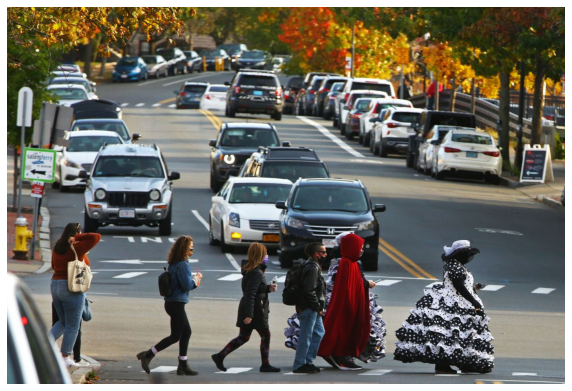

In [34]:
image_path = './examples/test.jpg'  #@param {type:"string"}
display_image(image_path, size=display_input_size)

/var/folders/fc/n5827zt91vb65jnqcsgpv5cr0000gn/T/ipykernel_27778/1268475391.py:52: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.isin(np.arange(len(roi_scores), dtype=np.int), nmsed_indices),


number of valid indices 254
Building text embeddings...


100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


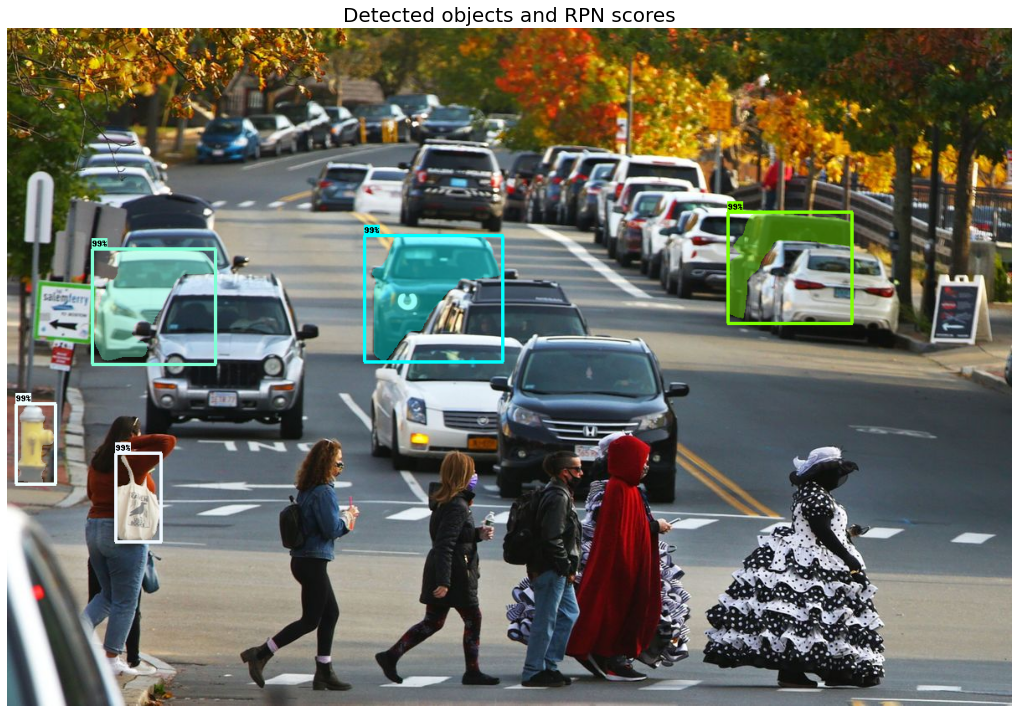

Detection counts: 5


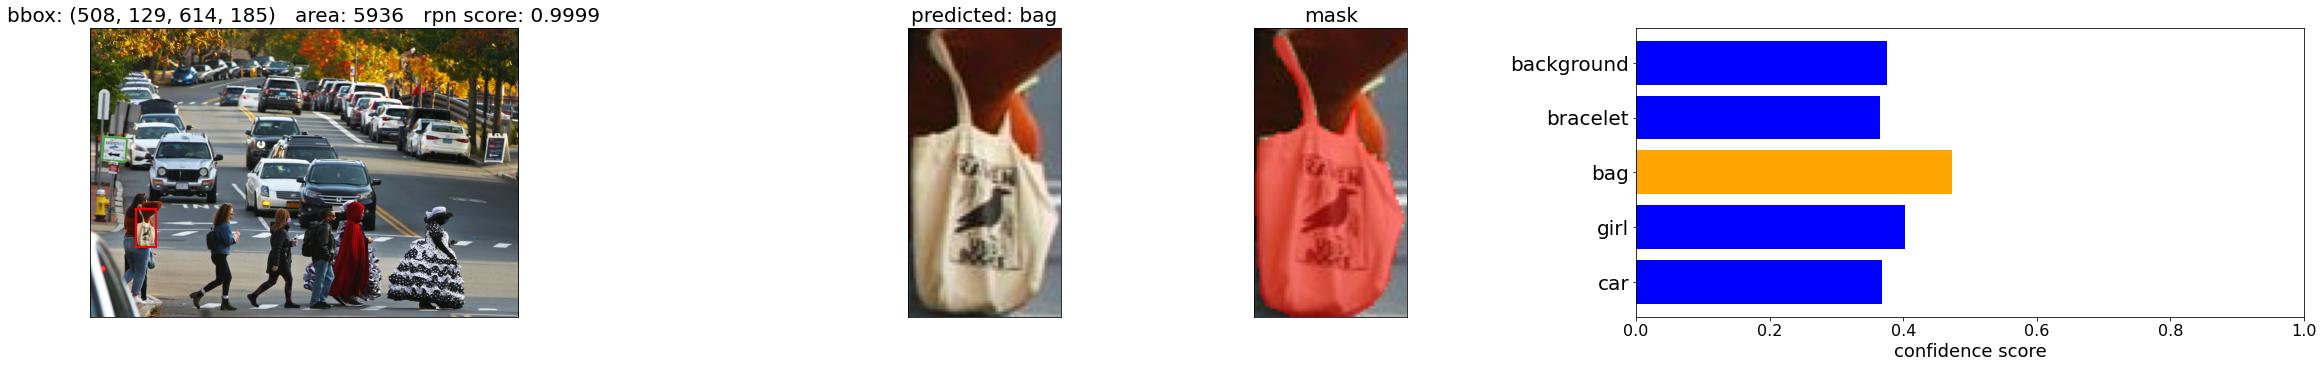

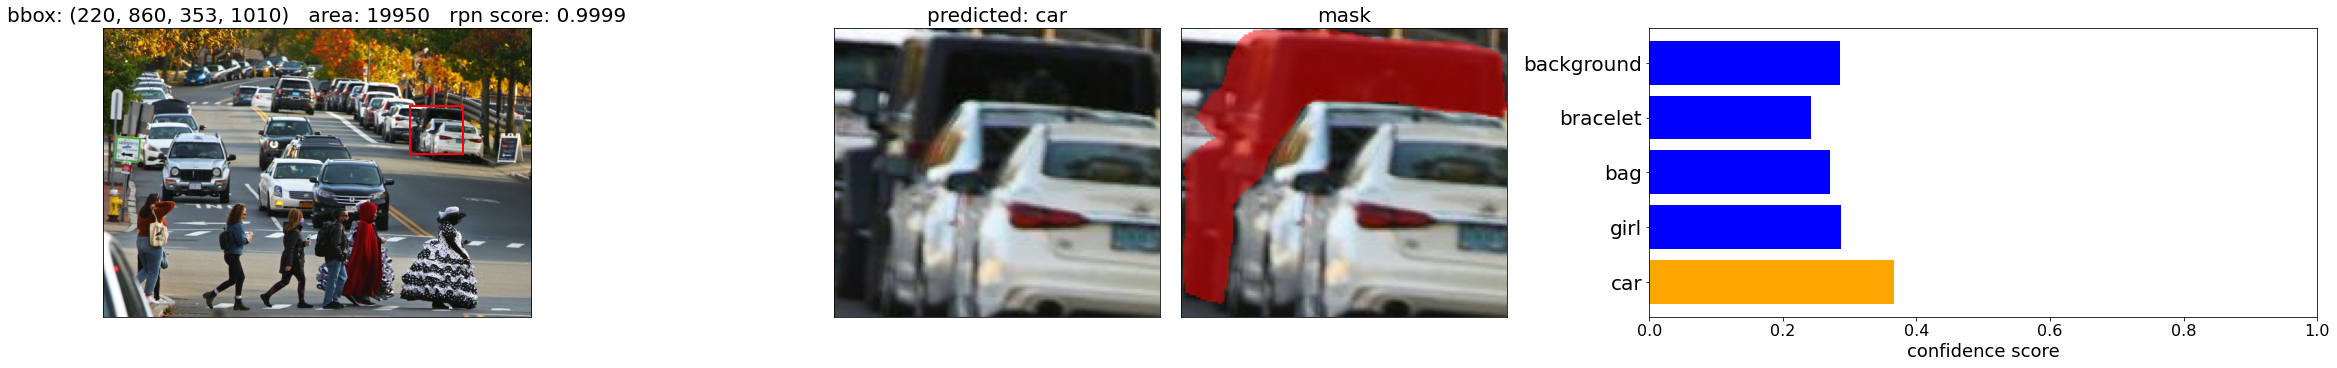

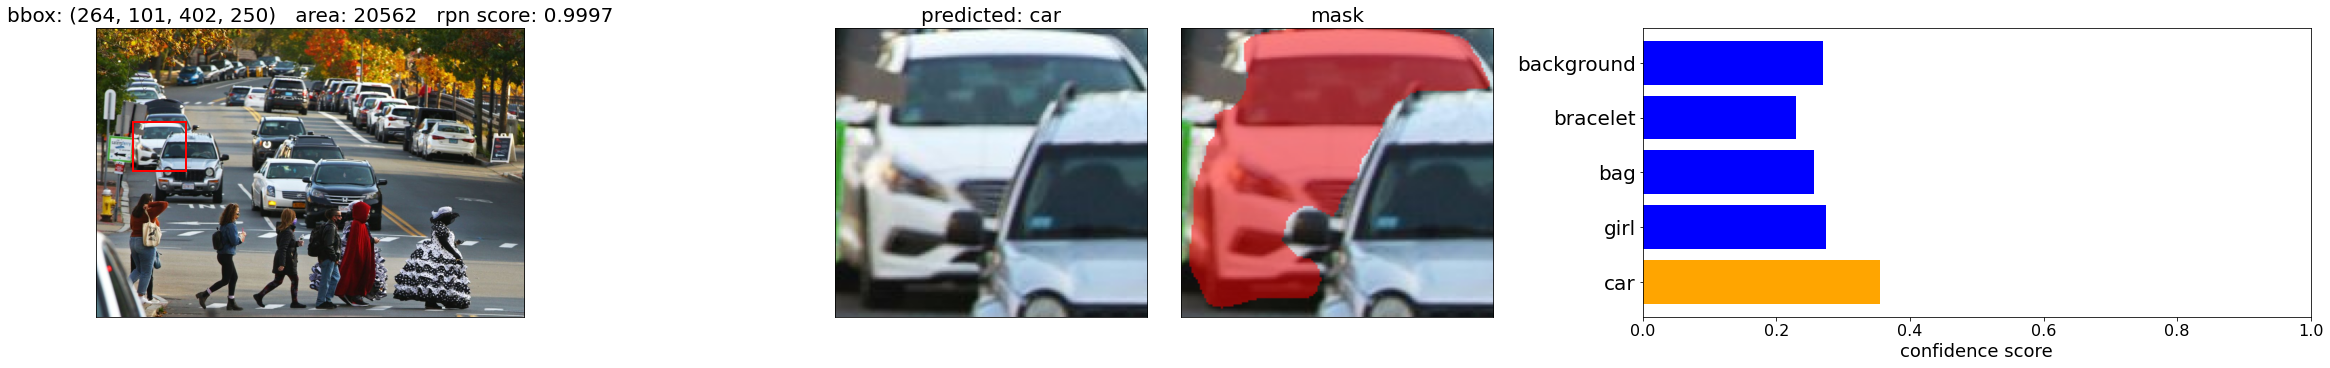

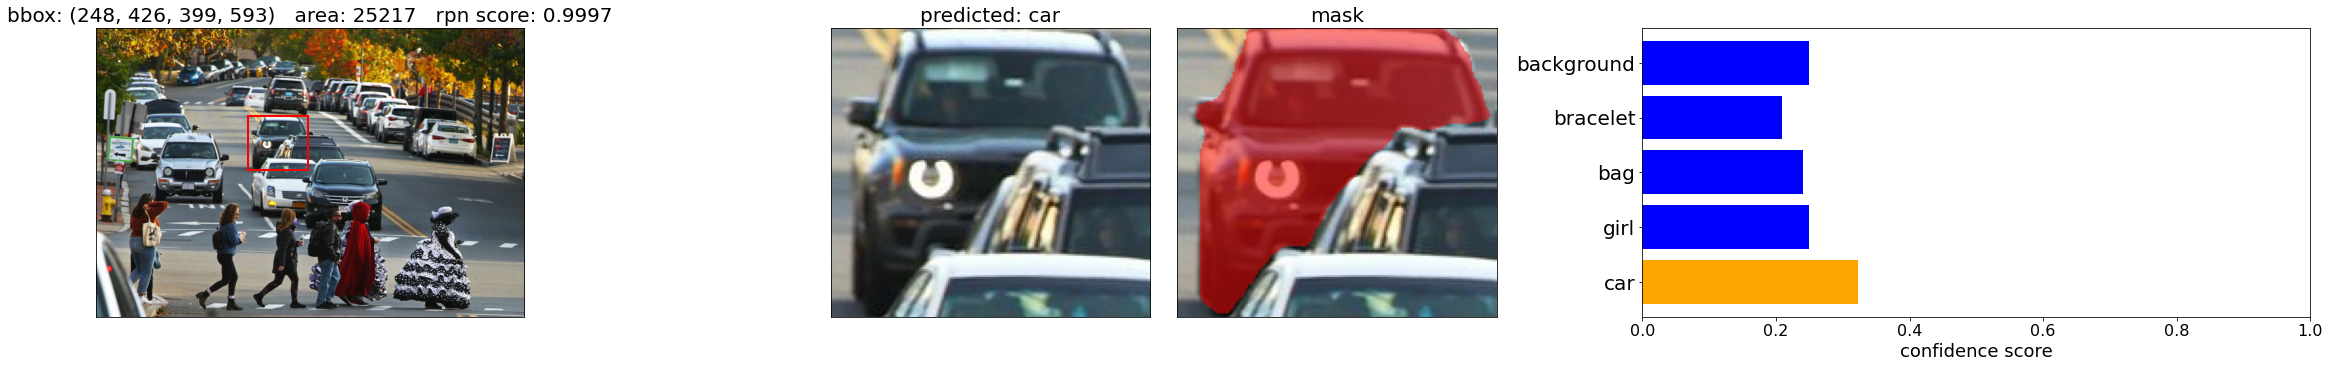

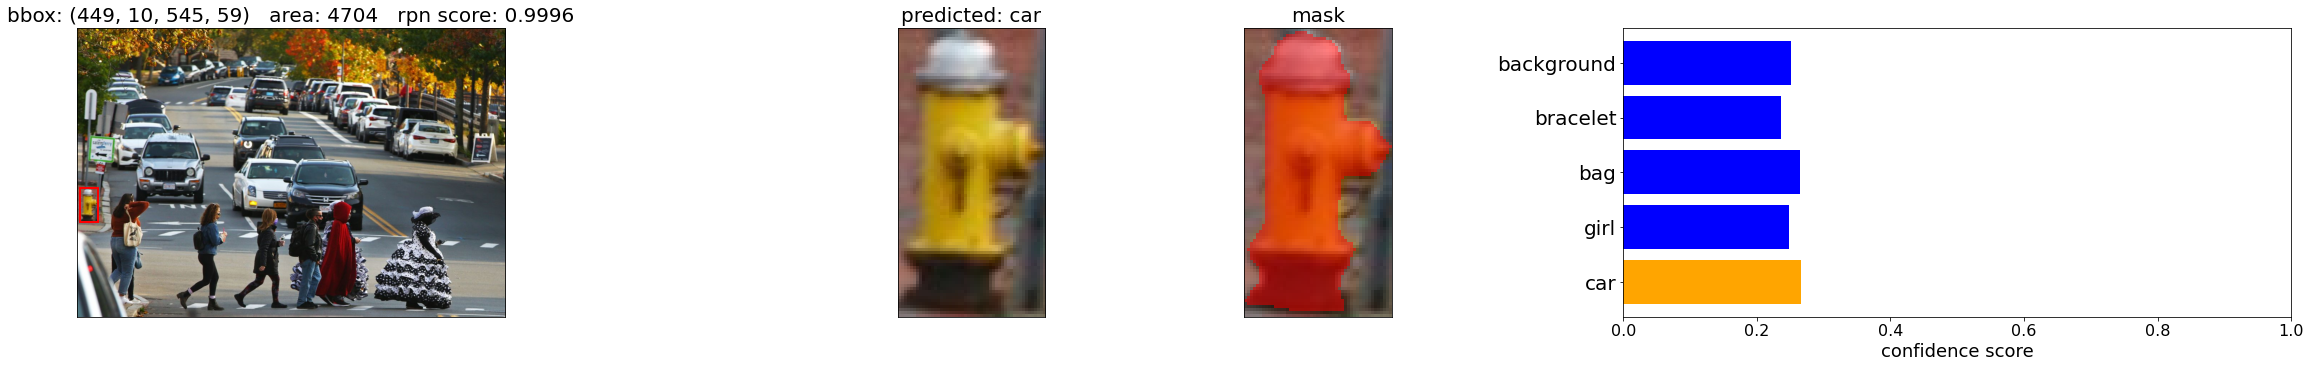

In [35]:
category_name_string = ';'.join(['bracelet', 'bag', 'girl', 'car']) ## + background

max_boxes_to_draw = 5 #@param {type:"integer"}
nms_threshold = 0.6 #@param {type:"slider", min:0, max:0.9, step:0.05} -- Non Maximum Suppression
min_rpn_score_thresh = 0.9  #@param {type:"slider", min:0, max:1, step:0.01}
min_box_area = 220 #@param {type:"slider", min:0, max:10000, step:1.0}
params = max_boxes_to_draw, nms_threshold, min_rpn_score_thresh, min_box_area

main(image_path, category_name_string, params)
#@markdown Orange bar means the prediction with maximum score over text inputs. 